### SHAP on MNIST

This is an example of SHAP on image data. If using this explainer, please cite the original work: https://github.com/slundberg/shap. `ShapImage` is not a model-agnostic method as `ShapTabular`. It only support Tensorflow or PyTorch models.

In [1]:
# This default renderer is used for sphinx docs only. Please delete this cell in IPython.
import plotly.io as pio
pio.renderers.default = "png"

In [2]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

from omnixai.data.image import Image
from omnixai.explainers.vision import ShapImage

The following code loads the training and test datasets. We recommend using `Image` to represent a batch of images. `Image` can be constructed from a numpy array or a Pillow image. In this example, `Image` is constructed from a numpy array containing a batch of digit images.

In [3]:
# Load the MNIST dataset
img_rows, img_cols = 28, 28
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()

if tf.keras.backend.image_data_format() == 'channels_first':
    x_train = x_train.reshape(x_train.shape[0], 1, img_rows, img_cols)
    x_test = x_test.reshape(x_test.shape[0], 1, img_rows, img_cols)
    input_shape = (1, img_rows, img_cols)
else:
    x_train = x_train.reshape(x_train.shape[0], img_rows, img_cols, 1)
    x_test = x_test.reshape(x_test.shape[0], img_rows, img_cols, 1)
    input_shape = (img_rows, img_cols, 1)

# Use `Image` objects to represent the training and test datasets
train_imgs, train_labels = Image(x_train.astype('float32'), batched=True), y_train
test_imgs, test_labels = Image(x_test.astype('float32'), batched=True), y_test

The preprocessing function takes an `Image` instance as its input and outputs the processed features that the ML model consumes. In this example, the pixel values are normalized to [0, 1].

In [4]:
preprocess_func = lambda x: np.expand_dims(x.to_numpy() / 255, axis=-1)

We train a simple convolutional neural network for this task. The network has two convolutional layers and one dense hidden layer. 

In [5]:
batch_size = 128
num_classes = 10
epochs = 10

x_train = preprocess_func(train_imgs)
x_test = preprocess_func(test_imgs)
y_train = tf.keras.utils.to_categorical(y_train, num_classes)
y_test = tf.keras.utils.to_categorical(y_test, num_classes)

model = tf.keras.models.Sequential()
model.add(tf.keras.layers.Conv2D(
    32, kernel_size=(3, 3), activation='relu', input_shape=input_shape))
model.add(tf.keras.layers.Conv2D(64, (3, 3), activation='relu'))
model.add(tf.keras.layers.MaxPooling2D(pool_size=(2, 2)))
model.add(tf.keras.layers.Dropout(0.1))
model.add(tf.keras.layers.Flatten())
model.add(tf.keras.layers.Dense(128, activation='relu'))
model.add(tf.keras.layers.Dropout(0.1))
model.add(tf.keras.layers.Dense(num_classes))

model.compile(
    loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
    optimizer=tf.keras.optimizers.Adam(),
    metrics=['accuracy']
)
model.fit(
    x_train, y_train,
    batch_size=batch_size,
    epochs=epochs,
    verbose=1,
    validation_data=(x_test, y_test)
)
score = model.evaluate(x_test, y_test, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Epoch 1/10
469/469 [==============================] - 2s 5ms/step - loss: 0.1724 - accuracy: 0.9487 - val_loss: 0.0458 - val_accuracy: 0.9855
Epoch 2/10
469/469 [==============================] - 2s 5ms/step - loss: 0.0466 - accuracy: 0.9852 - val_loss: 0.0333 - val_accuracy: 0.9885
Epoch 3/10
469/469 [==============================] - 2s 5ms/step - loss: 0.0298 - accuracy: 0.9906 - val_loss: 0.0323 - val_accuracy: 0.9891
Epoch 4/10
469/469 [==============================] - 2s 5ms/step - loss: 0.0207 - accuracy: 0.9933 - val_loss: 0.0286 - val_accuracy: 0.9903
Epoch 5/10
469/469 [==============================] - 2s 5ms/step - loss: 0.0158 - accuracy: 0.9949 - val_loss: 0.0295 - val_accuracy: 0.9907
Epoch 6/10
469/469 [==============================] - 2s 5ms/step - loss: 0.0125 - accuracy: 0.9962 - val_loss: 0.0290 - val_accuracy: 0.9904
Epoch 7/10
469/469 [==============================] - 2s 5ms/step - loss: 0.0109 - accuracy: 0.9963 - val_loss: 0.0283 - val_accuracy: 0.9902
Epoch 

To initialize `ShapImage`, we need to set the following parameters:
  
  - `model`: The ML model to explain, e.g., `torch.nn.Module` or `tf.keras.Model`.
  - `preprocess_function`: The preprocessing function that converts the raw data into the inputs of `model`.

In [6]:
explainer = ShapImage(
    model=model,
    preprocess_function=preprocess_func
)

We can simply call `explainer.explain` to generate explanations for this classification task. `ipython_plot` plots the generated explanations in IPython. Parameter `index` indicates which instance to plot, e.g., `index = 0` means plotting the first instance in `test_imgs[0:5]`.

Instructions for updating:
Simply pass a True/False value to the `training` argument of the `__call__` method of your layer or model.


Using TensorFlow backend.
keras is no longer supported, please use tf.keras instead.


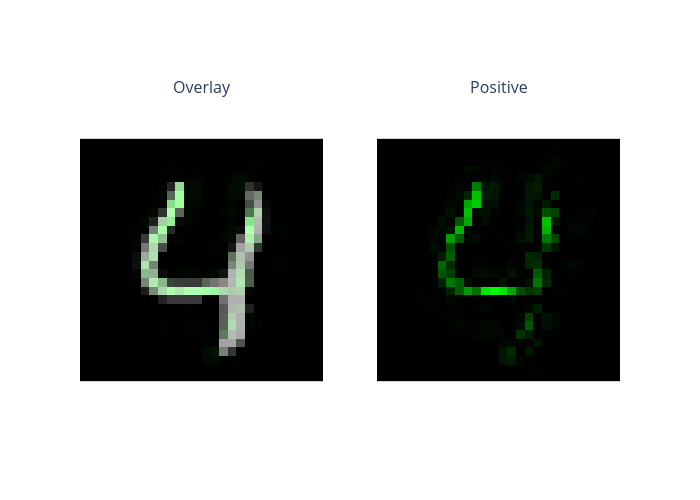

In [7]:
explanations = explainer.explain(test_imgs[0:5])
explanations.ipython_plot(index=4)